In [1]:
import ee
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geetools
import eemont
import geemap
from ee_extra.TimeSeries.core import getTimeSeriesByRegion

from masks import mask_MODIS_clouds, MODIS_Mask_QC, mask_s2_clouds, mask_s2_clouds_collection, csPlus_mask_collection
import masks

# Path to the private key file
key_path = 'Access/ee-martinparker637-e68fde65abb4.json'

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=['https://www.googleapis.com/auth/earthengine'])

# Initialize Earth Engine with the service account credentials
ee.Initialize(credentials)

In [48]:
def initialise_comparison(instrument = 'COPERNICUS/S2_SR_HARMONIZED', 
                                 coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0],
                                 country = 'DE', crop_type = 'M', year = 2019, root_directory = ''):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    grid_cell_lon = coord[1]
    grid_cell_lat = coord[0]
    f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(1500),{'ID':'A'})
    f1c = ee.FeatureCollection([f1])
    IC = (ee.ImageCollection(instrument)
         .filterBounds(f1c)
         .filterDate(f'{year}-01-01',f'{year}-12-31')
         .spectralIndices(['EVI','NDVI']))
    grid_cell = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(3000//2).bounds()
    world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100')
    crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gte(0)
    region = crop.clip(grid_cell).geometry()
    vectors = crop.reduceToVectors(**{
        'geometry': region,
        'scale': 100,
        'maxPixels': 1e13,
        'bestEffort':True,
        'eightConnected': False,
        })#.map(lambda x: x.buffer(-20))
    fig, ax = plt.subplots()
    return fig, ax, IC, vectors

In [60]:
def compare_cloud_masks(instrument = 'COPERNICUS/S2_SR_HARMONIZED', 
                                 coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                                 country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                                reducer_code = 'median'):
    fig, ax, IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory)
    for index, masker in enumerate([mask_s2_clouds_collection, csPlus_mask_collection]):
        masked = masker(IC)
        N=1
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
        
        ts = getTimeSeriesByRegion(masked,
            reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
            geometry = random_points,
            bands = ['EVI','NDVI'],#['B4','B8'],
            scale = 10)
        x = geemap.ee_to_df(ts)
        x['date'] = pd.to_datetime(x['date'])
        x = x.where(x['NDVI']!=-9999).dropna()
        name_choices = ['s2 cloud mask', 'google cloud mask']
        xreduced = x.where(x['reducer'] == reducer_code).dropna()
        ax.plot(xreduced['date'], xreduced['NDVI'], label = f'{name_choices[index]}, {reducer_code} reduced')
    fig.legend()
                                 

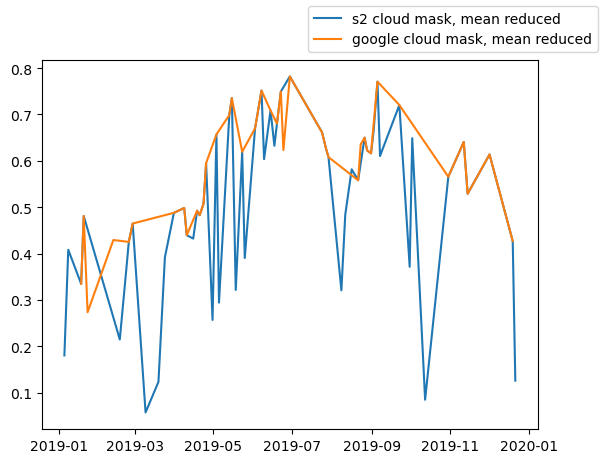

In [61]:
compare_cloud_masks(reducer_code = 'mean')

In [66]:
def compare_reducers(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median'):
    fig, ax, IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory)
    masked = csPlus_mask_collection(IC)
    N=5
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
    
    ts = getTimeSeriesByRegion(masked,
        reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
        geometry = random_points,
        bands = ['EVI','NDVI'],#['B4','B8'],
        scale = 10)
    x = geemap.ee_to_df(ts)
    x['date'] = pd.to_datetime(x['date'])
    x = x.where(x['NDVI']!=-9999).dropna()
    xmean = x.where(x['reducer'] == 'mean').dropna()
    xmedian = x.where(x['reducer'] == 'median').dropna()
    xmax = x.where(x['reducer'] == 'max').dropna()
    name_choices = ['s2 cloud mask', 'google cloud mask']
    ax.plot(xmean['date'], xmean['NDVI'], label = f'google cloud mask, mean reduced')
    ax.plot(xmedian['date'], xmedian['NDVI'], label = f'google cloud mask, median reduced')
    ax.plot(xmax['date'], xmax['NDVI'], label = f'google cloud mask, max reduced')
    fig.legend()

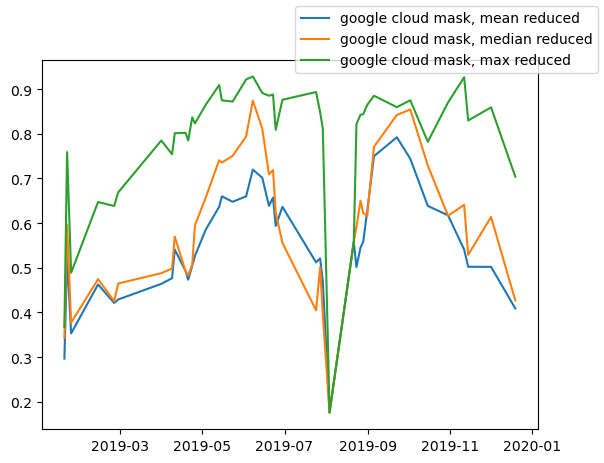

In [67]:
compare_reducers()

In [72]:
def compare_sample_sizes(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median'):
    fig, ax, IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory)
    for N in range(1, 100, 10):
        masked = csPlus_mask_collection(S2)
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})#
        ts = getTimeSeriesByRegion(masked,
            reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
            geometry = random_points,
            bands = ['EVI','NDVI'],#['B4','B8'],
            scale = 10)
        x = geemap.ee_to_df(ts)
        x['date'] = pd.to_datetime(x['date'])
        x = x.where(x['NDVI']!=-9999).dropna()
        xreduced = x.where(x['reducer'] == reducer_code).dropna()
        ax.plot(xreduced['date'], xreduced['NDVI'], label = f'Google cloud mask, {reducer_code} reduced')
    fig.legend()

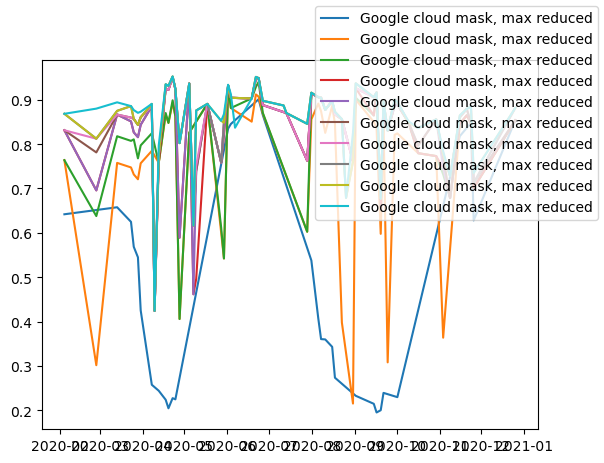

In [73]:
compare_sample_sizes(reducer_code = 'max')

In [26]:
coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
coord = coords[2]
grid_cell_lon = coord[1]
grid_cell_lat = coord[0]

N=10
coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
coord = coords[1]
f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(1500),{'ID':'A'})
f1c = ee.FeatureCollection([f1])
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
     .filterBounds(f1c)
     .filterDate('2020-01-01','2021-01-01')
     .spectralIndices(['EVI','NDVI']))

S2 = mask_s2_clouds_collection(S2)

grid_cell = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(3000//2).bounds()
world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100')
crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gte(0)
region = crop.clip(grid_cell).geometry()
vectors = crop.reduceToVectors(**{
    'geometry': region,
    'scale': 100,
    'maxPixels': 1e13,
    'bestEffort':True,
    'eightConnected': False,
    })#.map(lambda x: x.buffer(-20))
N=100
random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})#

ts = getTimeSeriesByRegion(S2,
    reducer = [ee.Reducer.mean(),ee.Reducer.median()],
    geometry = random_points,
    bands = ['EVI','NDVI'],#['B4','B8'],
    scale = 10)

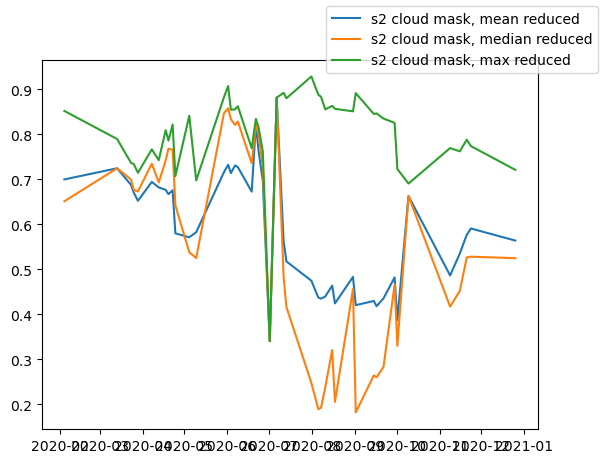

In [30]:
year = 2019
root_directory = ''
coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
coord = coords[2]
country_codes = {'DE': 93,
                'KEN': 133}
product_codes = {'M': 'product == "maize"',
                 'ww': 'product == "wintercereals"'}
grid_cell_lon = coord[1]
grid_cell_lat = coord[0]
filepath = 'Sentinel/Kenya/SatData0'
crop_type='M'
N=1
country = 'DE'
coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
coord = coords[1]
f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(1500),{'ID':'A'})
f1c = ee.FeatureCollection([f1])
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
     .filterBounds(f1c)
     .filterDate('2020-01-01','2021-01-01')
     .spectralIndices(['EVI','NDVI']))
grid_cell = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(1200//2).bounds()
world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100')
crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gte(0)
region = crop.clip(grid_cell).geometry()
vectors = crop.reduceToVectors(**{
    'geometry': region,
    'scale': 100,
    'maxPixels': 1e13,
    'bestEffort':True,
    'eightConnected': False,
    })#.map(lambda x: x.buffer(-20))
fig, ax = plt.subplots()
for index, masker in enumerate([csPlus_mask_collection]):#[mask_s2_clouds_collection]):#, csPlus_mask_collection]):
    masked = masker(S2)
    N=5
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
    
    ts = getTimeSeriesByRegion(masked,
        reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
        geometry = random_points,
        bands = ['EVI','NDVI'],#['B4','B8'],
        scale = 10)
    x = geemap.ee_to_df(ts)
    x['date'] = pd.to_datetime(x['date'])
    x = x.where(x['NDVI']!=-9999).dropna()
    xmean = x.where(x['reducer'] == 'mean').dropna()
    xmedian = x.where(x['reducer'] == 'median').dropna()
    xmax = x.where(x['reducer'] == 'max').dropna()
    name_choices = ['s2 cloud mask', 'google cloud mask']
    ax.plot(xmean['date'], xmean['NDVI'], label = f'{name_choices[index]}, mean reduced')
    ax.plot(xmedian['date'], xmedian['NDVI'], label = f'{name_choices[index]}, median reduced')
    ax.plot(xmax['date'], xmax['NDVI'], label = f'{name_choices[index]}, max reduced')
    
fig.legend()

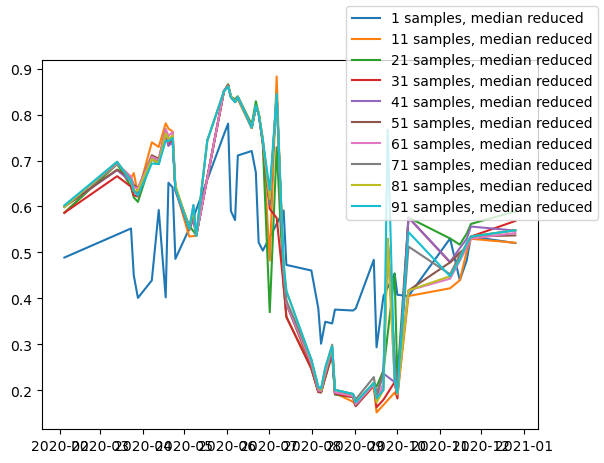

In [28]:
fig, ax = plt.subplots()
for N in range(1, 100, 10):
    masked = csPlus_mask_collection(S2)
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})#
    ts = getTimeSeriesByRegion(masked,
        reducer = [ee.Reducer.mean(),ee.Reducer.median()],
        geometry = random_points,
        bands = ['EVI','NDVI'],#['B4','B8'],
        scale = 10)
    x = geemap.ee_to_df(ts)
    x['date'] = pd.to_datetime(x['date'])
    x = x.where(x['NDVI']!=-9999).dropna()
    xmean = x.where(x['reducer'] == 'mean').dropna()
    xmedian = x.where(x['reducer'] == 'median').dropna()
    name_choices = ['s2 cloud mask', 'google cloud mask']
    #ax.plot(xmean['date'], xmean['NDVI'], label = f'{N} samples, mean reduced')
    ax.plot(xmedian['date'], xmedian['NDVI'], label = f'{N} samples, median reduced')
fig.legend()


In [199]:
grid_cell = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(1200//2).bounds()
crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gte(0)
region = crop.clip(grid_cell).geometry()
vectors = crop.reduceToVectors(**{
    'geometry': region,
    'scale': 100,
    'maxPixels': 1e13,
    'bestEffort':True,
    'eightConnected': False,
    })#.map(lambda x: x.buffer(-20))
N=1
random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})#
points = ee.FeatureCollection([ee.Feature(random_points.geometry().buffer(50))])

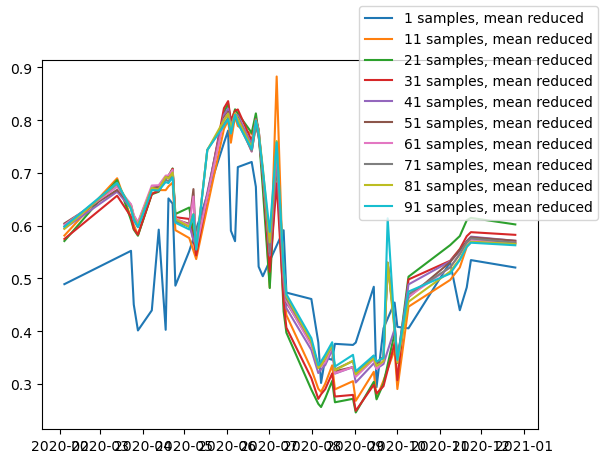

In [31]:
fig, ax = plt.subplots()
for N in range(1, 100, 10):
    masked = csPlus_mask_collection(S2)
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})#
    ts = getTimeSeriesByRegion(masked,
        reducer = [ee.Reducer.mean(),ee.Reducer.median()],
        geometry = random_points,
        bands = ['EVI','NDVI'],#['B4','B8'],
        scale = 10)
    x = geemap.ee_to_df(ts)
    x['date'] = pd.to_datetime(x['date'])
    x = x.where(x['NDVI']!=-9999).dropna()
    xmean = x.where(x['reducer'] == 'mean').dropna()
    xmedian = x.where(x['reducer'] == 'median').dropna()
    name_choices = ['s2 cloud mask', 'google cloud mask']
    ax.plot(xmean['date'], xmean['NDVI'], label = f'{N} samples, mean reduced')
    #ax.plot(xmedian['date'], xmedian['NDVI'], label = f'{name_choices[index]}, median reduced')
fig.legend()


In [169]:
coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
coord = coords[1]

In [170]:
coord

array([  54.4 ,   10.15, 7502.  ])

In [161]:
#maskList=ESA_mask.filter(ee.Filter.eq('aez_id', 12048)).toList(20);
#mask2ndImage=get_image_index(maize_mask, 2)
img2ndImage=get_image_index(S2, 5)
#date = ee.Date(img2ndImage.get('system:time_start'));
#print('Timestamp:', date)
#print(img2ndImage.date().getInfo())
#masked2ndImage=get_image_index(s2_filtered, 2)
#print(masked2ndImage.date().getInfo())
#mask2ndImage=maize_mask.mosaic()
#filteredImage = get_image_index(s2_filtered, 12)

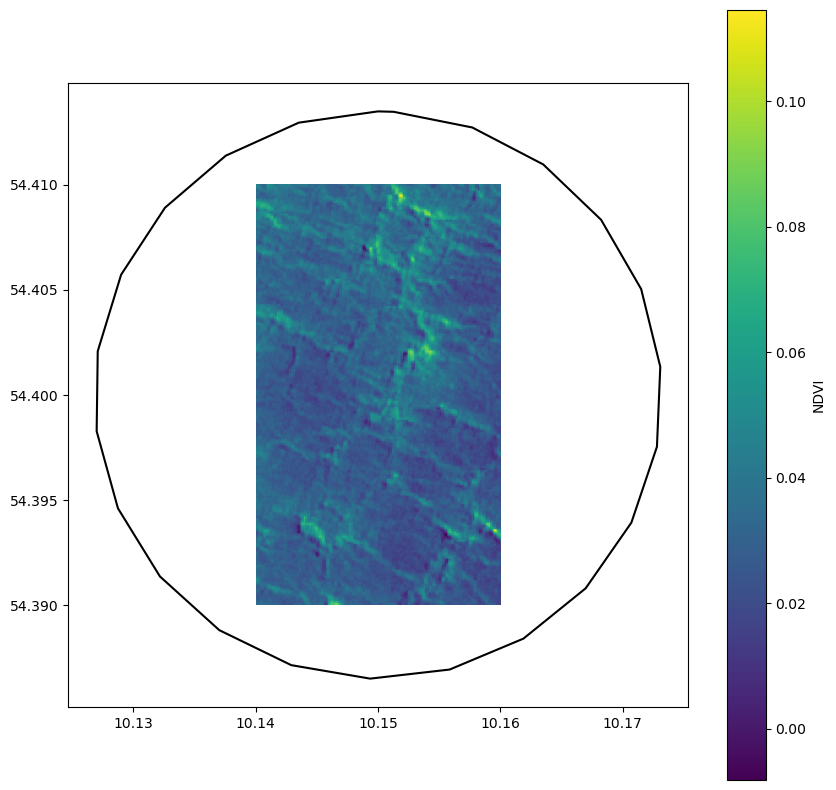

In [21]:
#fig, axs = plt.subplots(1, 3, figsize = (15, 45))
fig, axs = plt.subplots(figsize = (10, 10))
box_width=0.01
location = ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)
#masked2ndImage.geetools.plot(bands = ["cs"], ax=axs[0], region=location, scale = 0.00001)#
#filteredImage.geetools.plot(bands = ["ndvi"], ax=axs[0], region=location, scale = 0.00001)#
img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs, region=location,cmap="viridis", #fc=points, 
                          color="red")#, scale = 0.00001)
f1c.geetools.plot(ax = axs, boundaries=True)#, region=location)
#points.geetools.plot(ax = axs, boundaries=True)
cbar = fig.colorbar(axs.images[0], label="NDVI")
#cbar.set_clim([-4, 4])
#img2ndImage.geetools.plot(bands = ['cs'], ax = axs[2], region=location, scale = 0.00001)
#masked2ndImage.geetools.plot(bands = ['NDVI'], ax = axs[2], region=location, scale = 0.00001)

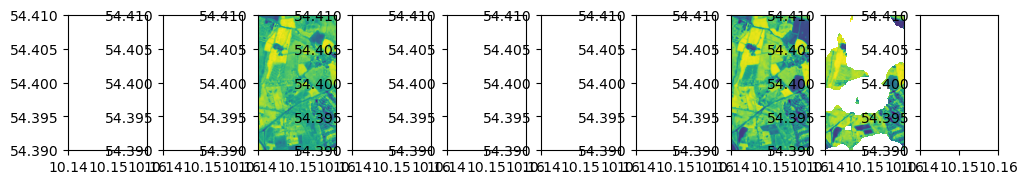

In [22]:
fig, axs = plt.subplots(1, 10, figsize = (12, 120))
for index in range(10):
    img2ndImage=get_image_index(masked, 6*index + 1)
    img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs[index], region=location,cmap="viridis",
                          color="k")  
fig.savefig('manyplots.jpg')

In [101]:
x = geemap.ee_to_df(ts)

In [25]:
coord

array([  54.4 ,   10.15, 7502.  ])

In [26]:
year = 2019
root_directory = ''
coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
coord = coords[1]
grid_cell_lon = coord[1]
grid_cell_lat = coord[0]
filepath = 'Sentinel/Kenya/SatData0'
crop_type='ww'
N=10
country = 'DE'

In [9]:
def get_image_index(image_collection, index):
    imgList = image_collection.toList(999)
    return ee.Image(ee.List(imgList).get(index))

In [62]:
country_codes = {'DE': 93,
                'KEN': 133}
product_codes = {'M': 'product == "maize"',
                 'ww': 'product == "wintercereals"'}
save_path = filepath #f'ndvi_download/{crop_type}_{year}_{grid_cell_lon:.4f}_{grid_cell_lat:.4f}_s2.csv'
#swap for engcrop when on gee
#uk_outline = ee.FeatureCollection('FAO/GAUL/2015/level0').filterMetadata('ADM0_CODE','equals',256)
country_outline = ee.FeatureCollection('FAO/GAUL/2015/level0').filterMetadata('ADM0_CODE','equals',country_codes[country])

# cropland = ee.FeatureCollection("users/spiruel/crop_labels/CEH_cropmap2021")
# crop = cropland.filterMetadata('crop_code','equals',crop_type)
world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100')
# Get a global mosaic for all agro-ecological zone (AEZ) of winter wheat
crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gte(0)

# proj = ee.Projection('EPSG:27700')

#for each grid cell, find the representative field
#buffer each point by 12km (/2) (the scale of the GCM data)
grid_cell = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(120//2).bounds()

#get sentinel 2 ndvi data
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').select(['B4', 'B8']).filterDate(f'{year}-11-01', f'{year}-12-31').filterBounds(grid_cell)
#s2 = s2.spectralIndices(['NDVI'])

s2_filtered = masks.csPlus_mask_collection(s2).filterDate(f'{year}-01-01', f'{year}-12-31').filterBounds(grid_cell)#-1

In [63]:
region = crop.clip(grid_cell).geometry()
vectors = crop.reduceToVectors(**{
    'geometry': region,
    'scale': 100,
    'maxPixels': 1e13,
    'bestEffort':True,
    'eightConnected': False,
    })#.map(lambda x: x.buffer(-20))
N=100
random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 42, 'maxError': 1})
#### For future reference, can put this set of random points into my function for reducing regions as an alternative to the full box. Don't know how much it brings tho. ####

In [64]:
#maskList=ESA_mask.filter(ee.Filter.eq('aez_id', 12048)).toList(20);
#mask2ndImage=get_image_index(maize_mask, 2)
img2ndImage=get_image_index(s2, 2)
#date = ee.Date(img2ndImage.get('system:time_start'));
#print('Timestamp:', date)
#print(img2ndImage.date().getInfo())
masked2ndImage=get_image_index(s2_filtered, 2)
#print(masked2ndImage.date().getInfo())
#mask2ndImage=maize_mask.mosaic()
#filteredImage = get_image_index(s2_filtered, 12)

<Axes: >

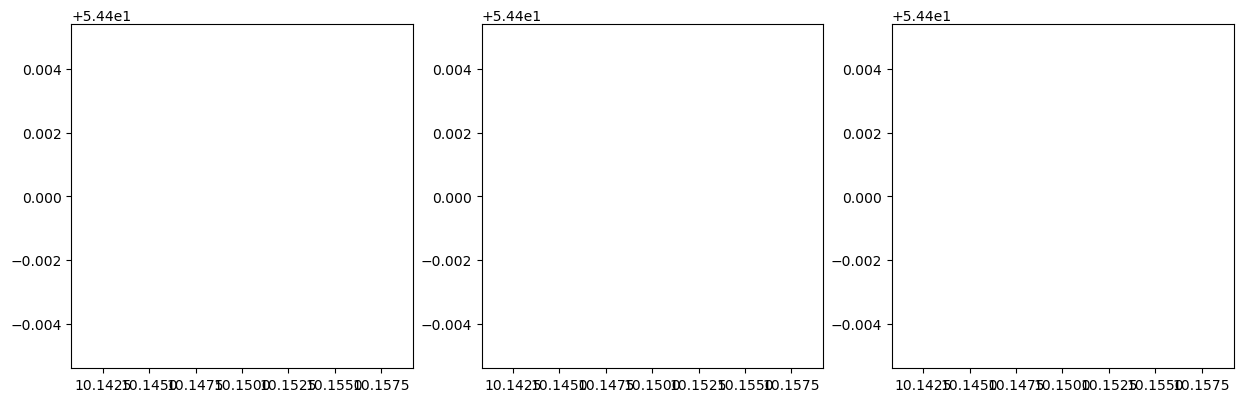

In [24]:
fig, axs = plt.subplots(1, 3, figsize = (15, 45))
location = grid_cell
masked2ndImage.geetools.plot(bands = ["cs"], ax=axs[0], region=location, scale = 0.00001)#
#filteredImage.geetools.plot(bands = ["ndvi"], ax=axs[0], region=location, scale = 0.00001)#
img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs[1], region=location, scale = 0.00001)
#img2ndImage.geetools.plot(bands = ['cs'], ax = axs[2], region=location, scale = 0.00001)
masked2ndImage.geetools.plot(bands = ['NDVI'], ax = axs[2], region=location, scale = 0.00001)

In [6]:
def get_mean(image, location, pixel_scale= 500):
    return image.set('mean', image.reduceRegion(ee.Reducer.mean(), location , pixel_scale))

def get_median(image, location, pixel_scale= 500):
    return image.set('median', image.reduceRegion(ee.Reducer.median(), location , pixel_scale))
def reduce_region_collection(image_collection, location, reducer_code = 'median', pixel_scale = 500):
    if reducer_code == 'mean':
        return image_collection.map(lambda img: get_mean(img, location, pixel_scale = pixel_scale))
    elif reducer_code == 'median':
        return image_collection.map(lambda img: get_median(img, location, pixel_scale = pixel_scale))
    else:
        print('invalid reducer code')
def collection_properties_to_frame(image_collection, coord, bands, reducer_code = 'median'):
    print('get times')
    timelist = image_collection.aggregate_array('system:time_start').getInfo()
    print('get bands')
    bandlist = image_collection.aggregate_array('median').getInfo()
    data = {'Time': timelist,
            'lat': [coord[0] for count in range(len(timelist))],
            'lon': [coord[1] for count in range(len(timelist))],
            'Stations_Id': [np.int64(coord[2]) for count in range(len(timelist))]
           }
    for band in bands:
        data[f'{reducer_code} {band}'] = [band_data[band] for band_data in bandlist]
    df = pd.DataFrame(data)
    df['formatted_time'] = pd.to_datetime(df['Time'], unit='ms').dt.strftime('%Y-%m-%d-%H-%M-%S')
    return df

In [174]:
fd = reduce_region_collection(s2_filtered, random_points, reducer_code = 'median', pixel_scale = 100)
df = collection_properties_to_frame(fd, coord, ['B4'], reducer_code = 'median')

get times
get bands


In [154]:
s2_bands = ['NDVI','cs','cs_cdf']
ts_s2 = s2_filtered.select(s2_bands).getTimeSeriesByRegion(**{
  'reducer': ee.Reducer.mean(),
  'geometry': random_points,#.buffer(10),
  'scale': 10,
  'maxPixels': 1e9
})

In [159]:
ts_s2.aggregate_array('NDVI').getInfo()

EEException: Collection.reduceColumns: Error in map(ID=0_20190101T100411_20190101T100408_T32TQT):
Element.setMulti: Parameter 'object' is required and may not be null.

In [156]:
ts_s2.propertyNames().getInfo()

[]

In [149]:
filtered_dataset_2.propertyNames().getInfo()

['date_range',
 'period',
 'system:visualization_0_min',
 'type_name',
 'keywords',
 'system:visualization_0_bands',
 'thumb',
 'description',
 'source_tags',
 'system:id',
 'visualization_0_max',
 'provider_url',
 'title',
 'sample',
 'tags',
 'system:visualization_0_max',
 'product_tags',
 'provider',
 'visualization_0_min',
 'system:version',
 'system:visualization_0_name',
 'visualization_0_name',
 'visualization_0_bands']

In [ ]:
#download the data
#try:
import geemap
data_s2 = geemap.ee_to_df(ts_s2)
#except Exception as e:
#    print(e)
#    print(f'failed to download Maize_{year}_{coord[1]:.2f}_{coord[1]:.2f}')
data_s2 = data_s2[data_s2['NDVI']!=-9999]
#save the data
data_s2.to_csv(save_path, index=False)
print(f'saved {save_path}')

In [2]:
root_directory = ''#'home/users/wlwc1989/phenology_dwd/'
#root_directory = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\'

In [3]:
coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')

In [4]:
coords[0]

array([  54.7833,    9.4333, 7501.    ])

In [5]:
def mask_other(img):
    return img.updateMask(img.neq(0))

In [6]:
def addNDVI(image, bands = ['sur_refl_b01', 'sur_refl_b02']):
    ndvi = image.normalizedDifference(bands).rename('ndvi')
    return image.addBands([ndvi])

In [7]:
def worldcereal_mask(image):
    ESA_mask = ee.ImageCollection("ESA/WorldCereal/2021/MODELS/v100")
    ESA_mask = ESA_mask.map(mask_other)
    ESA_mask_maize = ESA_mask.filter(ee.Filter.eq('season', 'tc-maize-main')).filter(ee.Filter.eq('aez_id', 12048)).filterBounds(location) 
    maize_mask = ESA_mask_maize.filter('product == "maize"').select(['classification'])
    return image.updateMask(maize_mask.mosaic())
    

In [107]:
bands = [f'B{n}' for n in range(4, 9)] #[f'sur_refl_b0{n}' for n in range(1, 5)]
#bands=['B4', 'B2']
coord_index = 0
pixel_scale = 250
#coord = [-0.277400, 35.215276]#[-1.54, 36.98, 0]
coord = coords[7]
box_width = 0.01
start_date = '2021-01-01'
end_date = '2021-12-31'
location = ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width) #ee.Geometry.Point(coord[:2])#

dataset = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") #"MODIS/061/MOD09A1")
filtered_dataset = dataset.filterDate(start_date, end_date).filterBounds(location).select(*bands)
filtered_dataset = filtered_dataset.map(lambda img: addNDVI(img, bands = ['B4', 'B8']))

csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

# Link S2 and CS+ results.
linkedCollection = filtered_dataset.linkCollection(csPlus, ['cs', 'cs_cdf'])

s2_filtered = linkedCollection.filterDate(f'{year-1}-10-01', f'{year}-10-01').filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',50)

#dataset = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")#"MODIS/061/MOD09A1")
#filtered_dataset = dataset.filterDate(start_date, end_date).filterBounds(location).select(*bands)
#filtered_dataset = filtered_dataset.map(lambda img: addNDVI(img, bands=bands))

ESA_mask = ee.ImageCollection("ESA/WorldCereal/2021/MODELS/v100")
ESA_mask = ESA_mask.map(mask_other)
AEZ_filter = ee.Filter.Or(ee.Filter.eq('aez_id', 46172), ee.Filter.eq('aez_id', 22190), ee.Filter.eq('aez_id', 12048), ee.Filter.eq('aez_id', 31114))
ESA_mask_maize = ESA_mask.filter(ee.Filter.eq('season', 'tc-maize-main')).filter(AEZ_filter).filterBounds(location) 
maize_mask = ESA_mask_maize.filter('product == "maize"').select(['classification'])

masked_dataset = filtered_dataset.map(lambda img: img.updateMask(maize_mask.mosaic()))
#masked_dataset = filtered_dataset.map(worldcereal_mask)

In [ ]:
cs_mask = csPlus.map(

In [115]:
masked_dataset_2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(start_date, end_date).filterBounds(location).select(*bands)
masked_dataset_2 = masked_dataset_2.map(lambda img: addNDVI(img, bands = ['B4', 'B8']))
masked_dataset_2 = masked_dataset_2#.map(lambda img: img.updateMask(maize_mask.mosaic()))
filtered_dataset_2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(start_date, end_date).filterBounds(location).select(*bands)
filetered_dataset_2 = filtered_dataset_2
filtered_dataset_2 = csPlus_mask_collection(filtered_dataset_2).map(lambda img: addNDVI(img, bands = ['B4', 'B8']))

In [17]:
def get_image_index(image_collection, index):
    imgList = image_collection.toList(999)
    return ee.Image(ee.List(imgList).get(index))

In [128]:
#maskList=ESA_mask.filter(ee.Filter.eq('aez_id', 12048)).toList(20);
#mask2ndImage=get_image_index(maize_mask, 2)
img2ndImage=get_image_index(filtered_dataset_2, 2)
#date = ee.Date(img2ndImage.get('system:time_start'));
#print('Timestamp:', date)
print(img2ndImage.date().getInfo())
masked2ndImage=get_image_index(masked_dataset_2, 2)
print(masked2ndImage.date().getInfo())
mask2ndImage=maize_mask.mosaic()
#filteredImage = get_image_index(s2_filtered, 12)

{'type': 'Date', 'value': 1613040342182}
{'type': 'Date', 'value': 1610016342649}


/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


<Axes: >

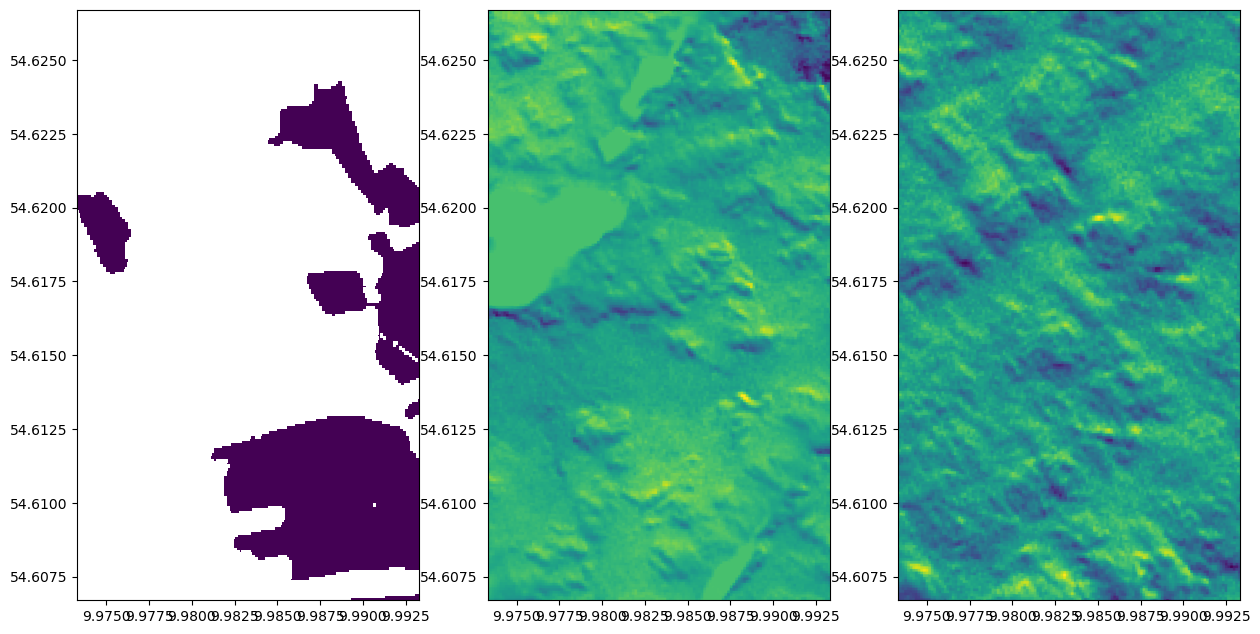

In [129]:
fig, axs = plt.subplots(1, 3, figsize = (15, 45))
mask2ndImage.geetools.plot(bands = ["classification"], ax=axs[0], region=location, scale = 0.00001)#
#filteredImage.geetools.plot(bands = ["ndvi"], ax=axs[0], region=location, scale = 0.00001)#
img2ndImage.geetools.plot(bands = ['ndvi'], ax = axs[1], region=location, scale = 0.00001)
img2ndImage.geetools.plot(bands = ['cs'], ax = axs[2], region=location, scale = 0.00001)
masked2ndImage.geetools.plot(bands = ['ndvi'], ax = axs[2], region=location, scale = 0.00001)

In [83]:
#bands = [f'sur_refl_b0{n}' for n in range(1, 5)]
bands = [f'B{n}' for n in range(4, 9)] 
coord_index = 0
pixel_scale = 250
#coord = [-1.5, 37, 0]
coord = [-0.277400, 35.215276, 0]
box_width = 0.0075
start_date = '2021-01-01'
end_date = '2021-12-31'

location = ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width) #ee.Geometry.Point(coord[:2])#
dataset = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") #"MODIS/061/MOD09A1")
filtered_dataset = dataset.filterDate(start_date, end_date).filterBounds(location) 
filtered_dataset = filtered_dataset.map(lambda img: addNDVI(img, bands = ['B4', 'B8']))
ESA_mask = ee.ImageCollection("ESA/WorldCereal/2021/MODELS/v100")
ESA_mask = ESA_mask.map(mask_other)
ESA_mask_maize = ESA_mask.filter(ee.Filter.eq('season', 'tc-maize-main')).filter(ee.Filter.eq('aez_id', 12048)).filterBounds(location) 
maize_mask = ESA_mask_maize.filter('product == "maize"').select(['classification'])

filtered_dataset = filtered_dataset.map(lambda img: img.updateMask(maize_mask.mosaic()))#.map(mask_s2_clouds)
filtered_dataset = csPlus_mask_collection(filtered_dataset)

time_series_data = filtered_dataset.select(*bands).map(lambda img: img.set('median', img.reduceRegion(ee.Reducer.median(), location , pixel_scale)))#.getInfo()#.getRegion(location, pixel_scale).getInfo()#.getRegion(location, 30).getInfo()#('B4')#.median()#.get('B4')#reduceColumns(ee.Reducer.median().setOutputs(['median']), [''])#.get('B4')
timelist = time_series_data.aggregate_array('system:time_start').getInfo()
print('times retrieved')
bandlist = time_series_data.aggregate_array('median').getInfo()
print('bands retrieved')
dataset = {'Time': timelist,
           'lat': [coord[0] for count in range(len(timelist))],
           'lon': [coord[1] for count in range(len(timelist))],
           'Stations_Id': [np.int64(coord[2]) for count in range(len(timelist))]
           }
for band in bands:
    dataset[f'Median {band}'] = [band_data[band] for band_data in bandlist]
df = pd.DataFrame(dataset)
df['formatted_time'] = pd.to_datetime(df['Time'], unit='ms').dt.strftime('%Y-%m-%d-%H-%M-%S')
if coord_index == 0:
    df_full = df
else:
    df_full = pd.concat([df_full, df])

times retrieved
bands retrieved


In [127]:
df_full['formatted_time'].dropna()

0     2021-01-06-08-10-10
1     2021-01-16-08-10-10
2     2021-01-21-08-10-11
3     2021-01-26-08-10-11
4     2021-01-31-08-10-11
5     2021-02-05-08-10-10
6     2021-02-15-08-10-09
7     2021-03-02-08-10-11
8     2021-03-07-08-10-10
9     2021-03-12-08-10-10
10    2021-03-17-08-10-10
11    2021-03-22-08-10-09
12    2021-03-27-08-10-09
13    2021-04-01-08-10-08
14    2021-04-06-08-10-08
15    2021-04-11-08-10-06
16    2021-04-16-08-10-06
17    2021-04-21-08-10-06
18    2021-04-26-08-10-06
19    2021-05-01-08-10-08
20    2021-05-06-08-10-08
21    2021-05-16-08-10-10
22    2021-05-21-08-10-11
23    2021-05-26-08-10-11
24    2021-05-31-08-10-12
25    2021-06-05-08-10-12
26    2021-06-10-08-10-11
27    2021-06-15-08-10-12
28    2021-06-20-08-10-11
29    2021-06-25-08-10-11
30    2021-06-30-08-10-13
31    2021-07-05-08-10-12
32    2021-07-20-08-10-14
33    2021-07-25-08-10-13
34    2021-08-04-08-10-12
35    2021-08-14-08-10-11
36    2021-08-19-08-10-13
37    2021-08-24-08-10-09
38    2021-0

In [98]:
class timeseries_downloader:
    def __init__(self, coords):
        self.coords = coords
        
    def initiate_image_collection(self, instrument = "COPERNICUS/S2_SR_HARMONIZED", bands = ['B4', 'B8'], 
                                  start_date = '2000-01-01', end_date = '2022-12-31', 
                                  QC_function = mask_s2_clouds_collection, pixel_scale = 500):
        self.bands = bands
        self.dataset = ee.ImageCollection(instrument).filterDate(start_date, end_date)
        self.dataset = QC_function(self.dataset)
        self.dataset = self.dataset.select(*bands)
        self.pixel_scale = pixel_scale
        
    def read_at_coords(self, box_width = 0.002):
        for coord_index, coord in enumerate(self.coords):
            print(coord_index)
            location = box_around_point(coord, box_width)
            filtered_dataset = self.dataset.filterBounds(location)
            filtered_dataset = reduce_region_collection(filtered_dataset, location, reducer_code = 'median', pixel_scale = self.pixel_scale)
            print('filtered!')
            df = collection_properties_to_frame(filtered_dataset, coord, self.bands, reducer_code = 'median')
            if coord_index == 0:
                self.df_full = df
            else:
                self.df_full = pd.concat([self.df_full, df])

def box_around_point(coord, box_width):
    '''
    coord: coordinate in (lat, lon) (?)
    '''
    return ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)

def get_mean(image, location, pixel_scale= 500):
    return image.set('mean', image.reduceRegion(ee.Reducer.mean(), location , pixel_scale))

def get_median(image, location, pixel_scale= 500):
    return image.set('median', image.reduceRegion(ee.Reducer.median(), location , pixel_scale))

def reduce_region_collection(image_collection, location, reducer_code = 'median', pixel_scale = 500):
    if reducer_code == 'mean':
        return image_collection.map(lambda img: get_mean(img, location, pixel_scale = pixel_scale))
    elif reducer_code == 'median':
        return image_collection.map(lambda img: get_median(img, location, pixel_scale = pixel_scale))
    else:
        print('invalid reducer code')

def collection_properties_to_frame(image_collection, coord, bands, reducer_code = 'median'):
    print('collecting...')
    timelist = image_collection.aggregate_array('system:time_start').getInfo()
    print('Times retrieved!')
    bandlist = image_collection.aggregate_array(reducer_code).getInfo()
    print('Data retrieved!')
    data = {'Time': timelist,
            'lat': [coord[0] for count in range(len(timelist))],
            'lon': [coord[1] for count in range(len(timelist))],
            'Stations_Id': [np.int64(coord[2]) for count in range(len(timelist))]
           }
    for band in bands:
        data[f'{reducer_code} {band}'] = [band_data[band] for band_data in bandlist]
    df = pd.DataFrame(data)
    df['formatted_time'] = pd.to_datetime(df['Time'], unit='ms').dt.strftime('%Y-%m-%d-%H-%M-%S')
    return df

In [99]:
startpoint = 0
endpoint = 2
savename = 'Sentinel/Kenya/SatData0'
print(startpoint, endpoint, savename)

root_directory = ''#'home/users/wlwc1989/phenology_dwd/'

#coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
coords = []
for lat in np.arange(-1, 1, 0.05):
    for lon in np.arange(35.05, 37.05, 0.05):
        coords.append([lat , lon, 0])

Sentinel_downloader = timeseries_downloader(coords[startpoint:endpoint])
Sentinel_downloader.initiate_image_collection(
    instrument = "COPERNICUS/S2_SR_HARMONIZED", bands = ['B4', 'B8'],
    start_date = '2020-01-01', 
    pixel_scale = 500, QC_function = lambda img: img)
#    QC_function = lambda IC: IC.map(MODIS_Mask_QC).map(mask_MODIS_clouds))
Sentinel_downloader.read_at_coords(box_width = 0.0001)# mask_s2_clouds_collection)
Sentinel_downloader.df_full.dropna().to_csv(root_directory + f"Saved_files/{savename}.csv")

#df.dropna().to_csv(root_directory + f"Saved_files/{savename}.csv")

0 2 Sentinel/Kenya/SatData0
0
filtered!
collecting...
Times retrieved!
Data retrieved!
1
filtered!
collecting...
Times retrieved!
Data retrieved!


In [ ]:
df_full

In [6]:
def satellite_data_at_coords(coords, start_date = '2000-01-01', end_date = '2022-12-31', instrument = "COPERNICUS/S2_SR_HARMONIZED", bands = ['B4', 'B8'], box_width = 0.002, pixel_scale = 500, QC_function = mask_s2_clouds):
    for coord_index, coord in enumerate(coords):
        print(coord_index)
        location = ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width) #ee.Geometry.Point(coord[:2])#
        dataset = ee.ImageCollection(instrument)
        dataset = QC_function(dataset)
        filtered_dataset = dataset.filterDate(start_date, end_date).filterBounds(location)
        time_series_data = filtered_dataset.select(*bands).map(lambda img: img.set('median', img.reduceRegion(ee.Reducer.median(), location , pixel_scale)))#.getInfo()#.getRegion(location, pixel_scale).getInfo()#.getRegion(location, 30).getInfo()#('B4')#.median()#.get('B4')#reduceColumns(ee.Reducer.median().setOutputs(['median']), [''])#.get('B4')
        timelist = time_series_data.aggregate_array('system:time_start').getInfo()
        print('times retrieved')
        bandlist = time_series_data.aggregate_array('median').getInfo()
        print('bands retrieved')
        dataset = {'Time': timelist,
                   'lat': [coord[0] for count in range(len(timelist))],
                   'lon': [coord[1] for count in range(len(timelist))],
                   'Stations_Id': [np.int64(coord[2]) for count in range(len(timelist))]
                   }
        for band in bands:
            dataset[f'Median {band}'] = [band_data[band] for band_data in bandlist]
        df = pd.DataFrame(dataset)
        df['formatted_time'] = pd.to_datetime(df['Time'], unit='ms').dt.strftime('%Y-%m-%d-%H-%M-%S')
        if coord_index == 0:
            df_full = df
        else:
            df_full = pd.concat([df_full, df])
    return df_full